<a href="https://colab.research.google.com/github/davidepelliciari/statistics/blob/master/integration_is.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uso dell'importance sampling nel calcolo di un integrale definito

Di seguito vogliamo stimare il seguente integrale:

 $I = \displaystyle \int_0^1 e^{-x^2} dx$

 Eseguiamo la stima prima attraverso un sample uniforme $U(0,1)$ e poi applicando l'importance sampling. In pratica viene usata una distribuzione diversa dall'integranda per il sampling per ottenere un'errore più piccolo sul risultato. Per una generica funzione $f(x)$, si può scrivere:

 $I = \displaystyle \int_a^b f(x)dx = E_U[f(x)]$

 Lo stimatore per questo integrale è:   $ \hat{I} = \frac{b-a}{N} \displaystyle \sum_{i=1}^N f(x_i)$.

 Si può dimostrare facilmente che $E[\hat{I}]$ è pari all'integrale. L'integrale $I$ può essere riscritto come:

 $ I = \displaystyle \int_a^b \frac{f(x)}{p(x)} p(x) dx = E_p\Big[\frac{f(x)}{p(x)}\Big]$

 Dunque scegliendo una pdf $p(x)$, dalla quale il sample è estratto, è possibile ottenere una stima dell'integrale. Scegliendo una buona pdf è possibile ridurre la varianza sulla stima dell'integrale.

# 1. Implementazione in uno script python

Importiamo qualche buona libreria che non fa mai male:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize
import math

E dichiariamo le variabili principali e le costanti matematiche di cui faremo uso:

In [0]:
# Dichiarazioni
a = 0
b = 1
e = math.e
Num = 10000   #Numero di samples da generare

truth = 0.7468241328    #valore vero dell'integrale, calcolato con wolfram Alpha

A questo punto definiamo le funzioni necessarie per calcolare l'integrale. Definiamo la funzione integranda, la pdf $p(x)$ da cui estrarre il sample e una funzione che restituisca il valore dello stimatore $\hat{I}$. Abbiamo scelto di usare la seguente pdf per l'estrazione del sample:

$p(x) = A e^{-x}$

Dove $A$ è una costante di normalizzazione pari a $A = \displaystyle \frac{e}{e-1}$.

In [0]:
def fun(x):     #integranda
    return e**(-x**2)


def P(x):       #pdf candidata per l'importance sampling
    A = e/(e-1)
    return A*e**(-x)


def integral(x,N):      #formula per lo stimatore di I secondo importance sampling
    sum = 0
    for i in range (0,N):
        sum = sum + (fun(x[i])/P(x[i]))
    return (1/N)*sum

Definiamo poi una funzione molto importante, la funzione randdist. Questa funzione permette di ottenere un sample di valori da una distribuzione di probabilità a scelta, nel nostro caso quest'ultima sarà proprio la $p(x)$.



In [0]:
def randdist(x, pdf, nvals):    #genera un sample distribuito secondo una pdf a scelta (P(x))
    """Produce nvals random samples from pdf(x), assuming constant spacing in x."""

    # get cumulative distribution from 0 to 1
    cumpdf = np.cumsum(pdf)
    cumpdf *= 1/cumpdf[-1]

    # input random values
    randv = np.random.uniform(size=nvals)

    # find where random values would go
    idx1 = np.searchsorted(cumpdf, randv)
    # get previous value, avoiding division by zero below
    idx0 = np.where(idx1==0, 0, idx1-1)
    idx1[idx0==0] = 1

    # do linear interpolation in x
    frac1 = (randv - cumpdf[idx0]) / (cumpdf[idx1] - cumpdf[idx0])
    randdist = x[idx0]*(1-frac1) + x[idx1]*frac1

    return randdist

Siamo pronti a calcolare la stima del nostro integrale seguendo due distribuzioni differenti per l'estrazione del sample:

1. Distribuzione uniforme $U(0,1)$, implementata dalla funzione del pacchetto numpy np.random.rand();

2. Distribuzione $p(x)$.

Generiamo un array di Num valori uniformemente distribuiti tra gli estremi di integrazione.

In [0]:
x = np.linspace(a,b,Num)

randdist_vals = randdist(x,P(x),Num)  #sample dalla pdf a scelta

x_unif = np.random.rand(Num)  #sample dalla pdf uniforme

Una volta fatto ciò possiamo stampare sul terminale i risultati ottenuti:

In [8]:
# PRINT DEI RISULTATI OTTENUTI E DISCOSTAMENTO DAL VALORE VERO

print("Valore calcolato (IMP SAMP): ", integral(randdist_vals,Num), "Discostamento:", (integral(randdist_vals,Num)-truth)/truth)
print("Valore calcolato (UNIFORM SAMP): ", integral(x_unif,Num), "Discostamento: ", (integral(x_unif,Num)-truth)/truth)

Valore calcolato (IMP SAMP):  0.7468174483721474 Discostamento: -8.950471147223692e-06
Valore calcolato (UNIFORM SAMP):  0.7485642669137585 Discostamento:  0.0023300453712367056


Possiamo poi vedere come si distribuiscono i valori estratti secondo la pdf da noi scelta:

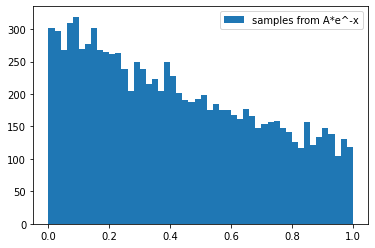

In [9]:
plt.hist(randdist_vals,50, label='samples from A*e^-x')
plt.legend()
plt.show()

Per valori di Num sempre maggiori si può notare come essi seguano effettivamente la pdf scelta.